In [1]:
import os
from dotenv import load_dotenv
from IPython.display import HTML, Image, Markdown, display
from google import genai
from google.genai.types import (
    FunctionDeclaration,
    GenerateContentConfig,
    GoogleSearch,
    HarmBlockThreshold,
    HarmCategory,
    Part,
    SafetySetting,
    ThinkingConfig,
    Tool,
    ToolCodeExecution,
)
from pydantic import BaseModel, Field
from typing import List, Optional

In [2]:
load_dotenv("config.env")
api_key = os.getenv("VERTEX_API_KEY")

In [3]:
CATALOG = {
    "tables": [
        {"Name": "Round table", "cost": 150, "radius": 0.8, "capacity": 6},
     {"Name": "Square table","cost": 100, "radius": 0.8, "capacity": 4} 
        ],
    "chairs": [
        {"Name": "Simple Chair", "cost": 85, "radius": 0.5,}
               ],
    "decorations": [
        {"Name": "plant", "cost": 45, "radius": 0.4},
        {"Name": "rug", "cost": 45, "radius": 0.4}
    ]
}

class Decoration(BaseModel):
    name: str = Field(description="Name of the ingredient.")
    size: float = Field(description="Size of the item")
    price: float = Field(description="Price of the item")

class Specifications(BaseModel):
    room_width: float = Field(description="Width of the room in meters.")
    room_length: float = Field(description="Length of the room in meters.")
    amount_chairs: int = Field(description="Number of chairs in the room.")
    amount_tables: int = Field(description="Number of tables in the room.")
    table_name: str = Field(description="Name of the chosen table type.")
    chair_name: str = Field(description="Name of the chosen chair type.")
    decorations: List[Decoration]

In [4]:
user_prompt = """"
"I need to organize a relaxed brainstorming session for 4 people in a 6x6 meter
room. Please design the space and give me a budget."
"""

prompt = f"""
You are a planning agent for events.
From the following items catalog: {CATALOG}, extract the room specifications and choose appropiate 
decoration from the following user requirements:
{user_prompt}
"""
client = genai.Client(vertexai=True, api_key=api_key)
response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config={
        "response_mime_type": "application/json",
        "response_json_schema": Specifications.model_json_schema(),
    },
)

specs = Specifications.model_validate_json(response.text)

room_width = specs.room_width
room_length = specs.room_length
amount_chairs = specs.amount_chairs
amount_tables = specs.amount_tables
name_table = specs.table_name
name_chair = specs.chair_name
decorations = specs.decorations
print(specs)

room_width=6.0 room_length=6.0 amount_chairs=4 amount_tables=1 table_name='Square table' chair_name='Simple Chair' decorations=[Decoration(name='plant', size=0.4, price=45.0), Decoration(name='rug', size=0.4, price=45.0)]


In [6]:
# Neurosymbolic reasoning to check constraints
import z3
import math

# Get item details from catalog
table_info = next(t for t in CATALOG["tables"] if t["Name"] == name_table)
chair_info = next(c for c in CATALOG["chairs"] if c["Name"] == name_chair)

# Create Z3 solver
solver = z3.Solver()

# Define symbolic variables for area calculations
total_area = z3.Real('total_area')
furniture_area = z3.Real('furniture_area')
table_area = z3.Real('table_area')
chair_area = z3.Real('chair_area')
decoration_area = z3.Real('decoration_area')

# Calculate actual areas
room_area = room_width * room_length
table_radius = table_info["radius"]
chair_radius = chair_info["radius"]

# Add constraints
solver.add(total_area == room_width * room_length)
solver.add(table_area == amount_tables * math.pi * table_radius**2)
solver.add(chair_area == amount_chairs * math.pi * chair_radius**2)

# Calculate decoration area
total_decoration_area = sum(math.pi * d.size**2 for d in decorations)
solver.add(decoration_area == total_decoration_area)

solver.add(furniture_area == table_area + chair_area + decoration_area)

# Constraint: furniture should not occupy more than 50% of room
solver.add(furniture_area < total_area * 0.5)

# Constraint: table capacity should accommodate all people
solver.add(table_info["capacity"] >= amount_chairs)

# Constraint: minimum spacing (at least 30% of room should be free)
solver.add(furniture_area < total_area * 0.7)

# Check if constraints are satisfied
if solver.check() == z3.sat:
    model = solver.model()
    
    # Calculate actual furniture area (not symbolic)
    actual_furniture_area = (amount_tables * math.pi * table_radius**2 + 
                             amount_chairs * math.pi * chair_radius**2 + 
                             total_decoration_area)
    
    print("✓ Constraints satisfied!")
    print(f"Room area: {room_area:.2f} m²")
    print(f"Furniture area: {actual_furniture_area:.2f} m²")
    print(f"Free space: {room_area - actual_furniture_area:.2f} m² ({(1 - actual_furniture_area/room_area)*100:.1f}%)")
    print(f"Table capacity: {table_info['capacity']} seats (Required: {amount_chairs})")
    
    # Calculate budget
    budget = (amount_tables * table_info["cost"] + 
              amount_chairs * chair_info["cost"] + 
              sum(d.price for d in decorations))
    print(f"\nEstimated Budget: ${budget:.2f}")
    print(f"  - {amount_tables}x {name_table}: ${amount_tables * table_info['cost']:.2f}")
    print(f"  - {amount_chairs}x {name_chair}: ${amount_chairs * chair_info['cost']:.2f}")
    for d in decorations:
        print(f"  - {d.name}: ${d.price:.2f}")
else:
    print("✗ Constraints NOT satisfied! The layout is not feasible.")
    print("Consider: reducing furniture, increasing room size, or changing items.")

✓ Constraints satisfied!
Room area: 36.00 m²
Furniture area: 6.16 m²
Free space: 29.84 m² (82.9%)
Table capacity: 4 seats (Required: 4)

Estimated Budget: $530.00
  - 1x Square table: $100.00
  - 4x Simple Chair: $340.00
  - plant: $45.00
  - rug: $45.00


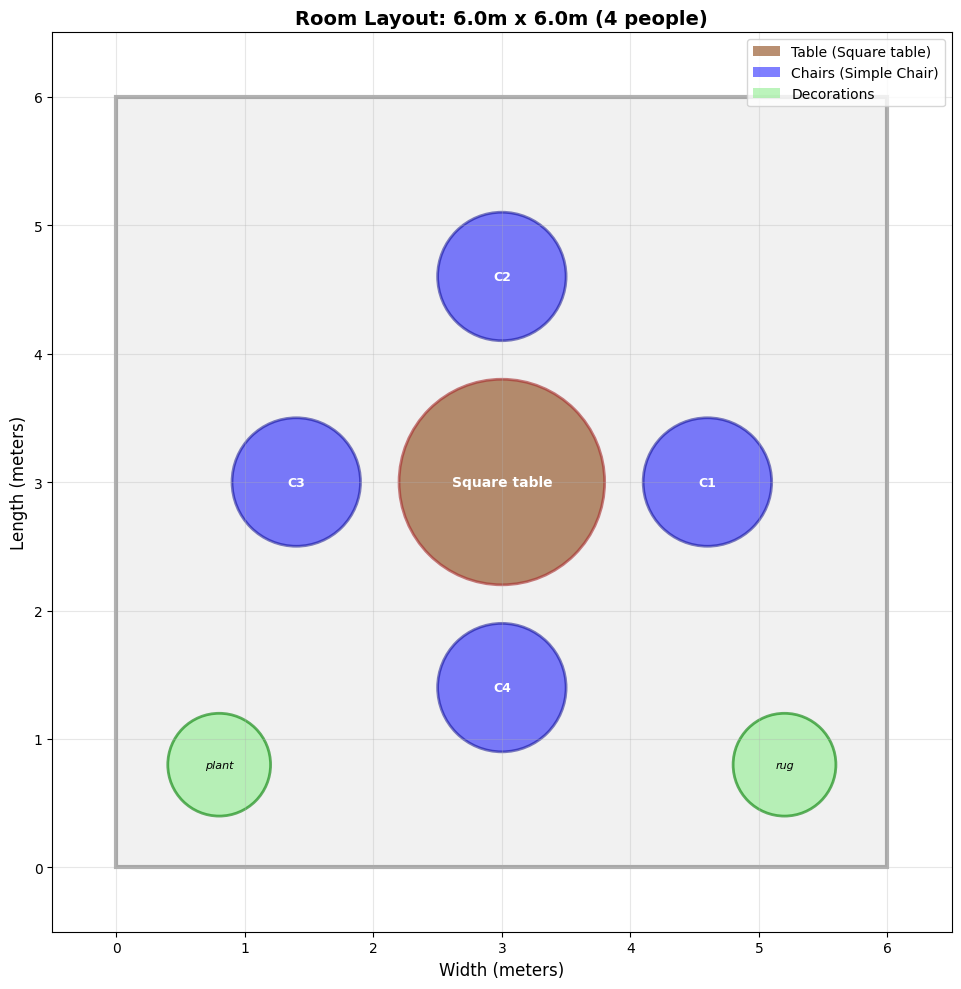

In [7]:
# Plotting the room layout
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Draw room boundaries
room_rect = patches.Rectangle((0, 0), room_width, room_length, 
                               linewidth=3, edgecolor='black', 
                               facecolor='lightgray', alpha=0.3)
ax.add_patch(room_rect)

# Place table at center
table_x, table_y = room_width / 2, room_length / 2
table_circle = patches.Circle((table_x, table_y), table_radius, 
                               linewidth=2, edgecolor='brown', 
                               facecolor='saddlebrown', alpha=0.6)
ax.add_patch(table_circle)
ax.text(table_x, table_y, name_table, ha='center', va='center', 
        fontsize=10, color='white', weight='bold')

# Place chairs around table in a circle
chair_positions = []
for i in range(amount_chairs):
    angle = 2 * math.pi * i / amount_chairs
    chair_x = table_x + (table_radius + chair_radius + 0.3) * math.cos(angle)
    chair_y = table_y + (table_radius + chair_radius + 0.3) * math.sin(angle)
    chair_positions.append((chair_x, chair_y))
    
    chair_circle = patches.Circle((chair_x, chair_y), chair_radius, 
                                   linewidth=2, edgecolor='darkblue', 
                                   facecolor='blue', alpha=0.5)
    ax.add_patch(chair_circle)
    ax.text(chair_x, chair_y, f'C{i+1}', ha='center', va='center', 
            fontsize=9, color='white', weight='bold')

# Place decorations in corners
decoration_positions = [
    (0.8, 0.8),  # bottom-left
    (room_width - 0.8, 0.8),  # bottom-right
]

for i, (dec, (dec_x, dec_y)) in enumerate(zip(decorations, decoration_positions)):
    if i < len(decoration_positions):
        dec_circle = patches.Circle((dec_x, dec_y), dec.size, 
                                     linewidth=2, edgecolor='green', 
                                     facecolor='lightgreen', alpha=0.6)
        ax.add_patch(dec_circle)
        ax.text(dec_x, dec_y, dec.name, ha='center', va='center', 
                fontsize=8, style='italic')

# Set plot properties
ax.set_xlim(-0.5, room_width + 0.5)
ax.set_ylim(-0.5, room_length + 0.5)
ax.set_aspect('equal')
ax.set_xlabel('Width (meters)', fontsize=12)
ax.set_ylabel('Length (meters)', fontsize=12)
ax.set_title(f'Room Layout: {room_width}m x {room_length}m ({amount_chairs} people)', 
             fontsize=14, weight='bold')
ax.grid(True, alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='saddlebrown', alpha=0.6, label=f'Table ({name_table})'),
    Patch(facecolor='blue', alpha=0.5, label=f'Chairs ({name_chair})'),
    Patch(facecolor='lightgreen', alpha=0.6, label='Decorations')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()